# Installing Packages

In [276]:
using Plots, Statistics, FinancialToolbox, Dates, ForwardDiff, Distributions
using Random, DiffEqBase.EnsembleAnalysis, Flux, Optimization, OptimizationFlux, DiffEqFlux, StochasticDiffEq, SciMLBase.EnsembleAnalysis
Random.seed!(1)

TaskLocalRNG()

# Initialising the Neural SDE
We specify the following underlying SDE: <br>
$dS_t = rS_tdt + \sigma S_tdW_t$ <br>
$S_0 = 100$ <br>
$r = 8\%$ <br>
$\sigma = 20\%$ <br>

In [163]:
S₀ = Float32[100.]  # Initial value of the SDE.
r = 0.08 # Risk-free rate of interest.
σ = 0.2 # Volatility. 
datasize = 30 # The size of the solution/stock paths we want to calculate. 
tspan = (0.0f0, 1.0f0) # The time horizon we wish to obtain the stock path over. 
tsteps = range(tspan[1], tspan[2], length = datasize) # Each time step we want a stock price.

0.0f0:0.03448276f0:1.0f0

# Pre-training drift coefficent
We pre-train the drift coefficent to be consistent with the no-arbitrage requirements.

In [487]:
# Pre training the drift coefficient, no-arbitrage condition
gridsize = 1000;
Func(x) = r*x;
X_Training = collect(range(0,stop=10,length=gridsize));
Y_Training = Func.(X_Training);

X_Testing = collect(range(0.01,stop=5,length=gridsize));
Y_Testing = Func.(X_Testing)

data = []
for i in 1:length(X_Training)
    push!(data, ([X_Training[i]], Y_Training[i]))
end

Pre_NSDE_Drift = Flux.Chain(Flux.Dense(1,1))
plt1 = plot(X_Testing ,[Y_Testing  Pre_NSDE_Drift(X_Testing')'],title="Diffusion Coefficient Before Training",label=["CEV Diffusion Coefficient" "Neural Network"], xlabel = "S",ylabel = "Diffusion Coefficient") # before training

loss_drift(x, y) = Flux.mse(Pre_NSDE_Drift(x), y)
opt_drift = Descent(0.01)
ps = Flux.params(Pre_NSDE_Drift)

for epoch in 1:500 
    Flux.train!(loss_drift, ps, data, opt_drift);
end

plt3 = plot(X_Testing ,[Y_Testing Pre_NSDE_Drift(X_Testing')'],title="Drift Coefficient After Training",label=["CEV Drift Coefficient" "Neural Network"], xlabel = "S",ylabel = "Drift Coefficient"); # before training


In [4]:
p1, re1 = Flux.destructure(Pre_NSDE_Drift)
Q = 16; 
Pre_NSDE_Diffusion = Flux.Chain(Flux.Dense(1,Q,elu),Flux.Dense(Q,Q,elu),Flux.Dense(Q,1));  
p2, re2 = Flux.destructure(Pre_NSDE_Diffusion)

Pre_NSDE = NeuralDSDE(Pre_NSDE_Drift , Pre_NSDE_Diffusion, tspan, SOSRI(), saveat = tsteps, reltol = 1e-1, abstol = 1e-1) # Specifying the neural SDE.

NeuralDSDE()

# Specifying the Training and Testing Data
We use the closed-form Black-Scholes call option pricing formulae to generate a training data set.

In [5]:
K = range(70, 130, length = 1000)
BS_Price = zeros(1,length(K))

for i in 1:length(K)
    BS_Price[i] = blsprice(100,K[i],r,tspan[2],σ,0.0)
end 

plt1 = plot(K,BS_Price',title="Black-Scholes Call Prices",label = "Black-Scholes Call Price",xlabel = "Strike",ylabel = "Price");

# Training the Neural SDE

In [6]:
function predict_neuralsde(p, u = S₀) 
  return Array(Pre_NSDE(u, p)) # Returns an array of stock prices/SDE solutions at each time point. 
end

function loss_neuralsde(p; n = 10000)
u = repeat(reshape(S₀, :, 1), 1, n)
stock = predict_neuralsde(p,u)[1,:,end]
    
NSDE_call = map(i->exp(-r*tspan[2]).*mean(maximum([stock .- K[i] zeros(size(stock))], dims = 2)),1:length(K))

loss = sum(abs2, NSDE_call - BS_Price')  
 return loss , NSDE_call  
end   

loss_neuralsde (generic function with 1 method)

In [7]:
list_plots = []
iter = 0
loss1 = zeros(1,10000)
# Callback function to observe training
callback = function (p, loss, NSDE_call; doplot = false)
  global list_plots, iter

  if iter == 0
    list_plots = []
  end
  iter += 1

  # loss against current data
  display(loss)
    display(iter)
     loss1[iter] = loss

  return false
end

#4 (generic function with 1 method)

In [8]:
t1 = now()

opt = ADAM()

# First round of training with n = 10000
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=10000), adtype)
optprob = Optimization.OptimizationProblem(optf, Pre_NSDE.p)
result1 = Optimization.solve(optprob, opt, callback = callback, maxiters = 50)  # 50 iterations of training. 

13737.658633699168

1

12768.33379154192

2

11419.417423728179

3

10377.432474058482

4

9395.968458642885

5

8151.356879716539

6

6686.062811818955

7

5852.739746535726

8

4643.014185257564

9

3414.6373992877643

10

2664.351748192099

11

2183.5487393831368

12

1606.6188073829098

13

1023.4207662448084

14

613.4650422826419

15

513.4079218553538

16

529.6991188103483

17

462.0995767399985

18

918.9224947773661

19

904.2301783104826

20

919.1081835091799

21

1482.6207805613021

22

1347.630701401499

23

969.9974719141023

24

925.9924318030593

25

1176.9290406012701

26

1360.76822751758

27

906.4804990577315

28

656.4957975155284

29

568.5025259766247

30

417.927556235582

31

339.13740746070505

32

723.3107141965597

33

543.8946548067397

34

221.25862476858734

35

253.9739510399287

36

241.78949677009595

37

230.63208089613076

38

290.315786088165

39

266.0979636513986

40

268.3140307929596

41

239.81901132997857

42

246.59090614687426

43

253.85777238458533

44

371.1796267004477

45

235.3041331097433

46

212.26121660755112

47

123.47316565524777

48

146.28909652211732

49

64.25085087297309

50

64.25085087297309

51

u: 323-element Vector{Float32}:
  0.08485667
  0.004736787
 -0.4555013
 -0.45259878
 -0.3413448
 -0.12674597
  0.2780248
 -0.56546026
 -0.06508606
  0.24399729
 -0.12445611
  0.33490568
  0.084302776
  ⋮
 -0.21474993
  0.012790266
 -0.05594071
 -0.14095281
  0.1485274
 -0.31727144
  0.14206472
 -0.16280545
 -0.21092202
 -0.5351223
 -0.4959412
 -0.016583906

In [9]:
t2 = now()
time = t2 - t1 

224306 milliseconds

In [10]:
prob = result1.u
u1 = repeat(reshape(S₀, :, 1), 1, 100000)
a = predict_neuralsde(prob, u1)[1,:,:]
stock_price_NSDE = a[:,end]
NSDE_call_NSDE = map(i->exp(-r*tspan[2]).*mean(maximum([stock_price_NSDE .- K[i] zeros(size(stock_price_NSDE))], dims = 2)),1:length(K));

In [12]:
# Resume training
t3 = now()

optf2 = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=50000), adtype)
optprob2 = Optimization.OptimizationProblem(optf2, result1.u)
result2 = Optimization.solve(optprob2, opt, callback = callback, maxiters = 50)

65.84128194083644

52

16.517413552803088

53

16.18221541691297

54

12.72479739959242

55

1.3610051863238373

56

10.653840750556

57

17.914456988416184

58

67.90588591177764

59

3.6889799120056304

60

20.206703881042923

61

14.976442268163611

62

9.938351296187845

63

14.387798931129561

64

15.410304970204589

65

3.200852855141544

66

29.7186134416765

67

8.027563392784806

68

6.525317171578647

69

27.592204073139833

70

0.6606552912065984

71

1.0819497548660983

72

0.27389350186447275

73

0.6763927474296747

74

33.16610893311666

75

28.19937047283915

76

10.313791256591438

77

0.7213363833686736

78

8.14088535764436

79

7.554670321421535

80

20.95277095513364

81

15.021051345929783

82

31.888457985315434

83

8.031125159708758

84

15.879890547128

85

31.790084648724513

86

4.8358944424526475

87

13.327931630764224

88

20.61155903797689

89

15.238503725975006

90

8.379267711279532

91

24.90018350519458

92

1.1236880397705076

93

4.599897413637261

94

6.254195499912142

95

3.5727293300904956

96

27.959020847637838

97

30.683965087416677

98

1.3417550585700022

99

4.069322870016219

100

19.594539407098754

101

0.27389350186447275

102

u: 323-element Vector{Float32}:
  0.07988729
 -0.00022400549
 -0.45550108
 -0.4525988
 -0.34155732
 -0.13209145
  0.279273
 -0.56546026
 -0.06438224
  0.24530855
 -0.12976824
  0.33628774
  0.08568818
  ⋮
 -0.21610864
  0.013860683
 -0.056699317
 -0.1398285
  0.1463627
 -0.3183478
  0.14060248
 -0.16412336
 -0.20985118
 -0.53641826
 -0.49487028
 -0.017654754

In [13]:
t4 = now()
time1 = t4 - t3 

1298260 milliseconds

In [14]:
# Resume training
t5 = now()

optf3 = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=100000), adtype)
optprob3 = Optimization.OptimizationProblem(optf3, result2.u)
result3 = Optimization.solve(optprob3, opt, callback = callback, maxiters = 50)

0.10539792570757675

103

116.53838511712591

104

8.027794214683494

105

9.04959484731835

106

51.51221931926924

107

74.3692971823291

108

29.944727579852685

109

0.4416443472598637

110

5.025449617290089

111

33.67940361886763

112

46.500791762215464

113

48.723720579527495

114

6.469905923337317

115

3.2143551483475883

116

28.177070166480394

117

9.23466181635076

118

24.9243964322618

119

41.32858573493924

120

0.8369784302395675

121

3.861965020903523

122

33.74777012780303

123

42.71935434499608

124

12.314621539122399

125

5.55391549454335

126

7.0715652894958705

127

7.405515860397671

128

1.2787299441134354

129

10.417832848094463

130

5.993689665534618

131

4.4491811192063855

132

2.9363983715082607

133

3.006509238335843

134

0.7901106942189611

135

3.769429399630086

136

7.710572342507282

137

18.600144236664192

138

6.050210541465273

139

0.7270136906978509

140

0.22596403278271035

141

23.75640191697074

142

0.43195022664268123

143

5.340543590468415

144

2.5054214052279833

145

0.6767949562410214

146

7.806983917035157

147

1.8321740584145711

148

0.769240734059349

149

8.166105126047668

150

5.308634347390643

151

6.738894130026639

152

0.10539792570757675

153

u: 323-element Vector{Float32}:
  0.07988729
 -0.00022400549
 -0.45550108
 -0.4525988
 -0.34155732
 -0.13209145
  0.279273
 -0.56546026
 -0.06438224
  0.24530855
 -0.12976824
  0.33628774
  0.08568818
  ⋮
 -0.21610864
  0.013860683
 -0.056699317
 -0.1398285
  0.1463627
 -0.3183478
  0.14060248
 -0.16412336
 -0.20985118
 -0.53641826
 -0.49487028
 -0.017654754

In [114]:
t6 = now()
time1 = t6 - t5

17089053 milliseconds

In [489]:
prob1 = result3.u
u2 = repeat(reshape(S₀, :, 1), 1, 100000)
a1 = predict_neuralsde(prob1, u2)[1,:,:]
stock_price_NSDE1 = a1[:,end]
K = range(80, 120, length = 21)
BS_Price1 = zeros(1,length(K))

for i in 1:length(K)
    BS_Price1[i] = blsprice(100,K[i],r,tspan[2],σ,0.0)
end

NSDE_call_NSDE1 = map(i->exp(-r*tspan[2]).*mean(maximum([stock_price_NSDE1 .- K[i] zeros(size(stock_price_NSDE1))], dims = 2)),1:length(K))
plot(K,NSDE_call_NSDE1,title="Neural SDE Call Prices After Training",label = "Neural SDE Call Prices After Training",xlabel = "Strike",ylabel = "Price")
plt3 = plot!(K,BS_Price1',title="Neural SDE Call Prices After Training",label = "Black-Scholes Call Price",xlabel = "Strike",ylabel = "Price");

In [490]:
K = range(80, 120, length = 21)
BS_Vol = zeros(1,length(K))
Vol_After = zeros(1,length(K))

for i in 1:length(K)
    BS_Vol[i] = blsimpv(100,K[i],r,tspan[2],BS_Price1[i])
    Vol_After[i] = blsimpv(100,K[i],r,tspan[2],NSDE_call_NSDE1[i])
end 
plt19 = scatter(K,Vol_After',title="Call Prices",label = "Neural SDE Implied Volatility After Training",xlabel = "Strike",ylabel = "Implied Volatility");
scatter(plt19)
plt11 = plot!(K,BS_Vol', linewidth=2,c=:red,title="Implied Volatility",label = "Black-Scholes Implied Volatility");


# Plotting

In [221]:
using Gadfly, Fontconfig, Cairo, DataFrames, Compose, ColorSchemes, LinearAlgebra, Base;

In [466]:
prob1 = result3.u
n1 = 1000
u2 = repeat(reshape(S₀, :, 1), 1, n1)
y = predict_neuralsde(prob1, u2)[1,:,:]'
y1 = y[end,:]
m = S₀.*exp.(r.*1)
y_sort = y[:, sortperm(y[end,:])];
m = m[1]

108.32870676749586

In [450]:
n2 = 1000000
u3 = repeat(reshape(S₀, :, 1), 1, n2)
y3 = predict_neuralsde(prob1, u3)[1,:,:]'
y4 = y3[end,:]
mu = 0.08
sig = 0.2
LN = LogNormal(mu,sig)*100
s =  40:0.005:200
s = s[:,1]
LNPDF = pdf.(LN,s);


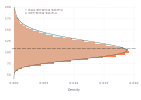

In [480]:
layer1 = layer(y=s, x=LNPDF, xmin=zeros(size(LNPDF)),Geom.path , Theme(alphas=[0.4], default_color=colorant"#2F4F4F") , xmax= LNPDF ,Geom.ribbon)
layer2 = layer(yintercept=[m], Geom.hline(color=["black"],style=[:dash]))
hist_plt = Gadfly.plot(layer2, layer1,
    y=y4,Guide.yticks(ticks = [50 75 100 125 150 175 200]), Geom.histogram(density=true, bincount=60, orientation=:horizontal), 
    Guide.xlabel("Density"), Guide.ylabel(nothing),Guide.manual_color_key("", ["Neural SDE Terminal Stock Price","GBM Terminal Stock Price"],["#FFA500","#2F4F4F"],pos=[0.1w,-0.45h],shape=[Gadfly.Shape.hline,Gadfly.Shape.hline]),
    Theme(key_label_font_size=6.5pt, major_label_font_size=9pt, key_position=:none, default_color=colorant"#FF7F50"),Coord.cartesian(xmin=0, xmax=0.02, ymin=40, ymax=200))


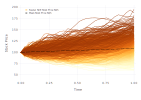

In [481]:
tsteps = range(tspan[1], tspan[2], length = datasize)
GBM_Means = S₀.*exp.(r.*tsteps)
GBM_Means = convert(Vector{Float32}, GBM_Means)

layer1 = Gadfly.layer(x = tsteps,y = GBM_Means, Geom.line,linestyle=[:dash],color=[colorant"black"])

layer2 = Gadfly.layer(y_sort, x=repeat(tsteps, inner=n1), y=Col.value, color=Col.index, Geom.line)
stock_path_plt = Gadfly.plot(layer1,layer2,Guide.xlabel("Time"),Guide.ylabel("Stock Price")
    ,Guide.xticks(ticks = [0 0.25 0.5 0.75 1]),Guide.yticks(ticks = [50 75 100 125 150 175 200])
    , Scale.ContinuousColorScale(p -> get(ColorSchemes.:YlOrBr_6, p)),Theme(key_label_font_size=6.5pt,major_label_font_size=9pt,key_position = :none),Guide.manual_color_key("", ["Neural SDE Stock Price Path","Mean Stock Price Path"],["#FFA500","#000000"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.hline,Gadfly.Shape.hline]),Coord.cartesian(xmin=0, xmax=1, ymin=40, ymax=200))
#:YlOrBr_6

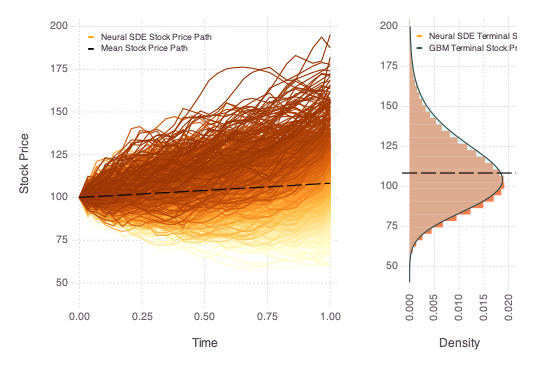

In [486]:
M = Array{Compose.Context}(undef, 1, 2)
M[1] = compose(context(0,0,2/3,1), render(stock_path_plt))
M[2] = compose(context(0,0,1/3,1), render(hist_plt))
plt_main = hstack(M[1],M[2])
#draw(PDF("myplot.pdf", 18cm, 10cm), plt_main)